In [53]:
#Joint blurring operator
def JCop(N):
    Ops = []
    for i in range(N):
        Ops.append(pylops.signalprocessing.Convolve2D((Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"))
    return pylops.BlockDiag(Ops, nproc=1)

#Joint TV regularizer
def JDop(N):
    Ops = []
    for i in range(N):
        Ops.append(pylops.FirstDerivative((Nz, Nx), axis=0, edge=False))
    Ops1 = []
    for i in range(N):
        Ops1.append(pylops.FirstDerivative((Nz, Nx), axis=1, edge=False))
    return [pylops.BlockDiag(Ops, nproc=1), pylops.BlockDiag(Ops1, nproc=1)]

#solving methods
#solving the normal equations
def normal_inv(imblur):
    imdeblur = pylops.optimization.leastsquares.normal_equations_inversion(
        Cop, imblur.ravel(), None, maxiter=5  # solvers need 1D arrays
    )[0]
    imdeblur = imdeblur.reshape(Cop.dims)
    return imdeblur

def Jnormal_inv(imblur, N, miter = 5):
    imdeblur = pylops.optimization.leastsquares.normal_equations_inversion(
        JCop(N), imblur.ravel(), None, maxiter= miter  # solvers need 1D arrays
    )[0]
    imdeblur = imdeblur.reshape(JCop(N).dims)
    return imdeblur

#Fast Iterative Shrinkage-Thresholding Algorithm
def fista(imblur, miter = 100):
    imdeblurfista = pylops.optimization.sparsity.fista(
        Cop * Wop.H, imblur.ravel(), eps=1e-1, niter=1
    )[0]
    imdeblurfista = imdeblurfista.reshape((Cop * Wop.H).dims)
    imdeblurfista = Wop.H * imdeblurfista
    return imdeblurfista

#Deblurring with TV
def TV_inv(imblur):
    imdeblurtv = pylops.optimization.sparsity.splitbregman(
        Cop,
        imblur.ravel(),
        Dop,
        niter_outer=150,
        niter_inner=1,
        mu=1.5,
        epsRL1s=[2e0, 2e0],
        tol=1e-6,
        tau=1.0,
        show=False,
        **dict(iter_lim=5, damp=1e-4)
    )[0]
    imdeblurtv = imdeblurtv.reshape(Cop.dims)
    return imdeblurtv

def JTV_inv(imblur, N):
    damp = 1e-4
    _JCop = JCop(N)
    _JDop = JDop(N)
    imdeblurtv = pylops.optimization.sparsity.splitbregman(
        _JCop,
        imblur.ravel(),
        _JDop,
        niter_outer=150,
        niter_inner=1,
        mu=1.5,
        epsRL1s=[damp, damp, damp, damp, damp, damp],
        tol=1e-6,
        tau=1.0,
        show=False,
        **dict(iter_lim=5, damp=1e-4)
    )[0]
    imdeblurtv = imdeblurtv.reshape(_JCop.dims)
    return imdeblurtv

#calculate cross contribution
def integrand(xi, method):
    if method == 'CG':
        val = (xi[0][0] * xi[1][1])**2 + (xi[0][0] * xi[2][1])**2 + (xi[1][0] * xi[0][1])**2 + (xi[1][0] * xi[2][1])**2 + (xi[2][0] * xi[0][1])**2 + (xi[2][0] * xi[1][1])**2 - 2 *(xi[0][0] * xi[0][1] * xi[1][0] * xi[1][1] + xi[0][0] * xi[0][1] * xi[2][0] * xi[2][1] + xi[1][0] * xi[1][1] * xi[2][0] * xi[2][1])
        return val
    if method == 'GD':
        val = 2 * (xi[0][0]**2 + xi[0][1]**2 + xi[1][0]**2 + xi[1][1]**2 + xi[2][0]**2 + xi[2][1]**2 - xi[0][0] * xi[1][0] - xi[0][1] * xi[1][1] - xi[0][0] * xi[2][0] - xi[0][1] * xi[2][1] - xi[1][0] * xi[2][0] - xi[1][1] * xi[2][1])
        return val
    if method == 'N':
        val = np.sqrt((xi[0][0] * xi[1][1])**2 + (xi[0][0] * xi[2][1])**2 + (xi[1][0] * xi[0][1])**2 + (xi[1][0] * xi[2][1])**2 + (xi[2][0] * xi[0][1])**2 + (xi[2][0] * xi[1][1])**2 - 2 *(xi[0][0] * xi[0][1] * xi[1][0] * xi[1][1] + xi[0][0] * xi[0][1] * xi[2][0] * xi[2][1] + xi[1][0] * xi[1][1] * xi[2][0] * xi[2][1]))
        return val
    
def pair_integrand(xi, method):
    val = (xi[0][0]**2 + xi[0][1]**2) * (xi[1][0]**2 + xi[1][1]**2) - (xi[0][0] * xi[1][0] + xi[0][1] * xi[1][1])**2
    if method == 'jCG':
        return val
    if method == "jN":
        for index, item in enumerate(val):
            if item < 0:
                val[index] = 0
        return np.sqrt(val)
    
def J(u_0, u_1, u_2, method):
    xi = np.array([[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_0), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_0)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_1), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_1)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_2), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_2)]])
    if method in ['CG', 'GD', 'N']:
        return np.divide(integrand(xi, method).sum(), Nz * Nx)
    xi01 = np.array([[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_0), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_0)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_1), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_1)]])
    xi02 = np.array([[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_0), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_0)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_2), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_2)]])
    xi12 = np.array([[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_1), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_1)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_2), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_2)]])    
    if method == "jCG":
        return np.divide(pair_integrand(xi01, 'jCG').sum(), Nz * Nx) + np.divide(pair_integrand(xi02, 'jCG').sum(), Nz * Nx) + np.divide(pair_integrand(xi12, 'jCG').sum(), Nz * Nx)
    if method == "jN":
        return np.divide(pair_integrand(xi01, 'jN').sum(), Nz * Nx) + np.divide(pair_integrand(xi02, 'jN').sum(), Nz * Nx) + np.divide(pair_integrand(xi12, 'jN').sum(), Nz * Nx)
    
#change from N = 3 to N = 1

def f_switch(u, a, b, method):
    return (f_CG(u[:Nz * Nx], u[Nz * Nx: 2 * Nz * Nx], u[2 * Nz * Nx:], a, b), Df(u[:Nz * Nx], u[Nz * Nx: 2 * Nz * Nx], u[2 * Nz * Nx:], a, b, method))

def vector_to_image(u, Nz, Nx):
    assert len(u) == 3 * Nz * Nx
    u_0, u_1, u_2 = np.reshape(u[:Nz * Nx], (Nz, Nx)), np.reshape(u[Nz * Nx: 2 * Nz * Nx],(Nz, Nx)), np.reshape(u[2 * Nz * Nx:], (Nz, Nx))
    return [u_0, u_1, u_2]

#solving the joint regularizer
def joint_TV_J(fun, x0, jac):
    return sp.optimize.minimize(fun, x0, method='L-BFGS-B', jac=None, bounds=[[0, 255], [0, 255]], options = {'maxiter' : 50})

def f_CG(u_0, u_1, u_2, a, b, rescale = 0.00392156862):
    return f_CG_aux(u_0, 0, a) + f_CG_aux(u_1, 1, a) + f_CG_aux(u_2, 2, a) + b * rescale * J(u_0, u_1, u_2, 'GD')

def f_CG_aux(vec, index, a, rescale = 0.00392156862):
    return 0.5 * (((Cop* vec - Jimblur[index].ravel())**2).sum()) + a * np.array([np.abs(Dop[0] * vec), np.abs(Dop[1] * vec)]).sum()
   
def Df_aux(u_0, u_1, u_2, index, a, b = 1000, eps = 1, rescale = 0.00392156862):
    #note that this is not the contribution in direction vec, the first derivatives of vec are present in the other direction, when we sum over all directions it is correct
    if index == 0:
        return Cop.H * ((Cop * u_0 - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * u_0) + np.square(Dop[1] * u_0) + eps**2)) - b * rescale * (np.square(Dop[0] * u_1) + np.square(Dop[1] * u_1) + np.square(Dop[0] * u_2) + np.square(Dop[1] * u_2))
    if index == 1:
        return Cop.H * ((Cop * u_1 - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * u_1) + np.square(Dop[1] * u_1) + eps**2)) - b * rescale * (np.square(Dop[0] * u_0) + np.square(Dop[1] * u_0) + np.square(Dop[0] * u_2) + np.square(Dop[1] * u_2))
    if index == 2:
        return Cop.H * ((Cop * u_2 - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * u_2) + np.square(Dop[1] * u_2) + eps**2)) - b * rescale * (np.square(Dop[0] * u_0) + np.square(Dop[1] * u_0) + np.square(Dop[0] * u_1) + np.square(Dop[1] * u_1))
 
    
def Df(u_0, u_1, u_2, a, b = 1000, eps = 1, method = "CG"): 
    if method == "CG":
        return np.array([Df_aux(u_0, u_1, u_2, 0, a, b), Df_aux(u_0, u_1, u_2, 1, a, b), Df_aux(u_0, u_1, u_2, 2, a, b)]).ravel()
    if method == "N":
        return np.array([Df_aux(u_0, 0, a, b), Df_aux(u_1, 1, a, b), Df_aux(u_2, 2, a, b)]).ravel()

def Df_fixed(vec, index, u, a, b, eps = 0.1, rescale = 0.00392156862, method = "CG"):
    if method == "CG":
        if index == 0:
            return Cop.H * ((Cop * vec - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * vec) + np.square(Dop[1] * vec) + eps**2)) - b * 0.5 * rescale * (np.square(Dop[0] * u[Nz * Nx: 2 * Nz * Nx]) + np.square(Dop[1] * u[Nz * Nx: 2 * Nz * Nx]) + np.square(Dop[0] * u[2 * Nz * Nx:]) + np.square(Dop[1] * u[2 * Nz * Nx:]))
        if index == 1:
            return Cop.H * ((Cop * vec - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * vec) + np.square(Dop[1] * vec) + eps**2)) - b * 0.5 * rescale * (np.square(Dop[0] * u[:Nz * Nx]) + np.square(Dop[1] * u[:Nz * Nx]) + np.square(Dop[0] * u[2 * Nz * Nx:]) + np.square(Dop[1] * u[2 * Nz * Nx:]))
        if index == 2:
            return Cop.H * ((Cop * vec - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * vec) + np.square(Dop[1] * vec) + eps**2)) - b * 0.5 * rescale * (np.square(Dop[0] * u[:Nz * Nx]) + np.square(Dop[1] * u[:Nz * Nx]) + np.square(Dop[0] * u[Nz * Nx: 2 * Nz * Nx]) + np.square(Dop[1] * u[Nz * Nx: 2 * Nz * Nx]))
    if method == "N":
        if index == 0:
            return Cop.H * ((Cop * vec - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * vec) + np.square(Dop[1] * vec) + eps**2)) - b * 0.5 * rescale * (np.square(Dop[0] * u[Nz * Nx: 2 * Nz * Nx]) + np.square(Dop[1] * u[Nz * Nx: 2 * Nz * Nx]) + np.square(Dop[0] * u[2 * Nz * Nx:]) + np.square(Dop[1] * u[2 * Nz * Nx:]))
        if index == 1:
            return Cop.H * ((Cop * vec - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * vec) + np.square(Dop[1] * vec) + eps**2)) - b * 0.5 * rescale * (np.square(Dop[0] * u[:Nz * Nx]) + np.square(Dop[1] * u[:Nz * Nx]) + np.square(Dop[0] * u[2 * Nz * Nx:]) + np.square(Dop[1] * u[2 * Nz * Nx:]))
        if index == 2:
            return Cop.H * ((Cop * vec - Jimblur[index].ravel())) - a * rescale * np.divide(1, np.sqrt(np.square(Dop[0] * vec) + np.square(Dop[1] * vec) + eps**2)) - b * 0.5 * rescale * (np.square(Dop[0] * u[:Nz * Nx]) + np.square(Dop[1] * u[:Nz * Nx]) + np.square(Dop[0] * u[Nz * Nx: 2 * Nz * Nx]) + np.square(Dop[1] * u[Nz * Nx: 2 * Nz * Nx]))
    
def f_CG_fixed(vec, index, u, a, b):
    if index == 0:
        return (f_CG(vec, u[Nz * Nx: 2 * Nz * Nx], u[2 * Nz * Nx:], a, b), Df_fixed(vec, 0, u, a, b, "CG"))
    if index == 1:
        return (f_CG(u[:Nz * Nx], vec, u[2 * Nz * Nx:], a, b), Df_fixed(vec, 1, u, a, b, "CG"))
    if index == 2:
        return (f_CG(u[:Nz * Nx], u[Nz * Nx: 2 * Nz * Nx], vec, a, b), Df_fixed(vec, 2, u, a, b, "CG"))

In [68]:
def generate_bounds(N, min_val, max_val):
    return [(min_val, max_val) for _ in range(N)]

def alg_A(im, a = 1, b = 1e-2, maxiter = 2000, ftol = 1e-6, gtol = 1e-6):
    result = sp.optimize.minimize(f_switch, x0 = np.array([im[0], im[1], im[2]]).ravel(), jac = True, method = 'L-BFGS-B', args = (a, b, 'CG'), bounds = generate_bounds(3 * Nz * Nx, 0, 255), options = {'maxiter' : maxiter, 'ftol' : ftol, 'gtol' : gtol})
    return vector_to_image(result.x, Nz, Nx)

def alg_D(im, a_aux = 1, b_aux = 1, maxiter_aux = 2000, ftol_aux = 1e-6, gtol_aux = 1e-6):
    newim = JTV_inv(im, 3)
    return alg_A(im = newim, maxiter = maxiter_aux, ftol = ftol_aux, gtol = gtol_aux)

def alg_E(im, a_aux = 0, b_aux = 1, maxiter_aux = 2000, ftol_aux = 1e-6, gtol_aux = 1e-6):
    newim = JTV_inv(im, 3)
    return alg_A(im = newim, maxiter = maxiter_aux, ftol = ftol_aux, gtol = gtol_aux)


In [70]:
#error measures
def calculate_psnr(original, compressed, max_pixel=255):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_mse(reference, candidate):
    assert len(reference) == len(candidate)
    return (np.square(reference - candidate)).mean(axis=None)

def plot_mse(reference, candidates):
    for candidate in candidates:
        mse_values = []
        for i in range(reference.shape[0]):
            mse = calculate_mse(reference[i,::], candidate[i,::])
            mse_values.append(mse)

        plt.plot(mse_values)

    plt.xlabel('RGB')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error (MSE) Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_result(image, imblur, imdeblurA, imdeblurB, imdeblurC):
    #image.shape must have length 2
    Nz, Nx = image.shape
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle("Two Channels", fontsize=14, fontweight="bold", y=0.95)
    ax1 = plt.subplot2grid((2, 5), (0, 0))
    ax2 = plt.subplot2grid((2, 5), (0, 1))
    ax3 = plt.subplot2grid((2, 5), (0, 2))
    ax4 = plt.subplot2grid((2, 5), (1, 0))
    ax7 = plt.subplot2grid((2, 5), (1, 1))
    ax5 = plt.subplot2grid((2, 5), (0, 3), colspan=2)
    ax6 = plt.subplot2grid((2, 5), (1, 3), colspan=2)
    ax1.imshow(image, cmap="viridis", vmin=0, vmax=250)
    ax1.axis("tight")
    ax1.set_title("Original")
    ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
    ax2.axis("tight")
    ax2.set_title("Blurred")
    ax3.imshow(imdeblurA, cmap="viridis", vmin=0, vmax=250)
    ax3.axis("tight")
    ax3.set_title("TV")
    ax4.imshow(imdeblurB, cmap="viridis", vmin=0, vmax=250)
    ax4.axis("tight")
    ax4.set_title("Algorithm D")
    ax7.imshow(imdeblurC, cmap="viridis", vmin=0, vmax=250)
    ax7.axis("tight")
    ax7.set_title("Algorithm E")
    ax5.plot(image[Nz // 2], "k")
    ax5.plot(imblur[Nz // 2], "--r")
    ax5.plot(imdeblurA[Nz // 2], "--g")
    ax5.plot(imdeblurB[Nz // 2], "--m")
    ax5.plot(imdeblurC[Nz // 2], "--b")
    ax5.axis("tight")
    ax5.set_title("Horizontal section")
    ax6.plot(image[:, Nx // 2], "k", label="Original")
    ax6.plot(imblur[:, Nx // 2], "--r", label="Blurred")
    ax6.plot(imdeblurA[:, Nx // 2], "--g", label="TV")
    ax6.plot(imdeblurB[:, Nx // 2], "--m", label="D")
    ax6.plot(imdeblurC[:, Nx // 2], "--b", label="E")
    ax6.axis("tight")
    ax6.set_title("Vertical section")
    ax6.legend(loc=5, fontsize="small")
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.savefig('twochannels.png')
    return

def plot_alg(A, B, C, D, E, F, G, TV, im, imblur):
    Nz, Nx = 50, 40
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95)
    ax1 = plt.subplot2grid((2, 5), (0, 0))
    ax2 = plt.subplot2grid((2, 5), (0, 1))
    ax3 = plt.subplot2grid((2, 5), (0, 2))
    ax4 = plt.subplot2grid((2, 5), (0, 3))
    ax5 = plt.subplot2grid((2, 5), (1, 0))
    ax6 = plt.subplot2grid((2, 5), (1, 1))
    ax7 = plt.subplot2grid((2, 5), (1, 2))
    ax8 = plt.subplot2grid((2, 5), (1, 3))
    ax9 = plt.subplot2grid((2, 5), (0, 4))
    ax10 = plt.subplot2grid((2, 5), (1, 4))
    ax1.imshow(A, cmap="viridis", vmin=0, vmax=250)
    ax1.axis("tight")
    ax1.set_title("A")
    ax2.imshow(B, cmap="viridis", vmin=0, vmax=250)
    ax2.axis("tight")
    ax2.set_title("B")
    ax3.imshow(C, cmap="viridis", vmin=0, vmax=250)
    ax3.axis("tight")
    ax3.set_title("C")
    ax4.imshow(D, cmap="viridis", vmin=0, vmax=250)
    ax4.axis("tight")
    ax4.set_title("D")
    ax5.imshow(E, cmap="viridis", vmin=0, vmax=250)
    ax5.axis("tight")
    ax5.set_title("E")
    ax6.imshow(F, cmap="viridis", vmin=0, vmax=250)
    ax6.axis("tight")
    ax6.set_title("F")
    ax7.imshow(G, cmap="viridis", vmin=0, vmax=250)
    ax7.axis("tight")
    ax7.set_title("G")
    ax8.imshow(TV, cmap="viridis", vmin=0, vmax=250)
    ax8.axis("tight")
    ax8.set_title("TV")
    ax9.imshow(im, cmap="viridis", vmin=0, vmax=250)
    ax9.axis("tight")
    ax9.set_title("Original")
    ax10.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
    ax10.axis("tight")
    ax10.set_title("Blurred")
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.savefig('deblurring_algs.png')
    return

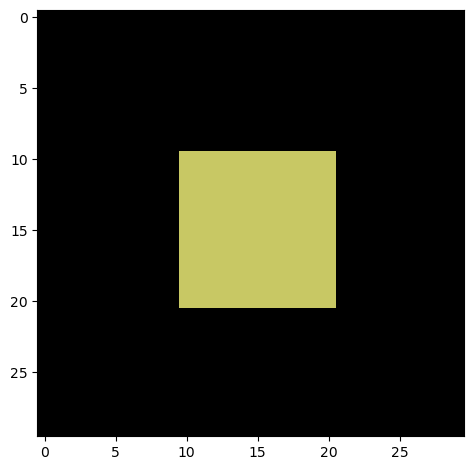

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf
import scipy as sp
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.draw import disk, rectangle, polygon
from skimage import io
import pylops

# Create a 30x30 image with RGB as the first dimension
image = np.zeros((30, 30, 3), dtype=np.uint8)

# Define colors
square_color = (200, 200, 100)   # yellow

# Draw a square
rr, cc = rectangle(start=(10, 10), end=(20, 20), shape=image.shape)
image[rr, cc] = square_color

# Display the image
io.imshow(image)
io.show()

30 30


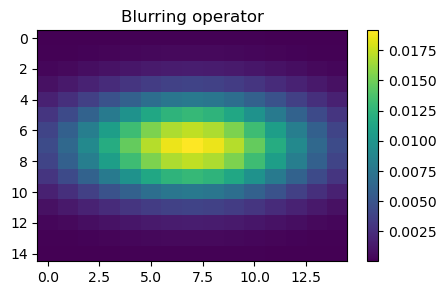

In [76]:
#import image
imR = image[:,:,0]
imG = image[:,:,1]
imB = image[:,:,2]

"""
imG = skimage.data.chelsea()[:, :, 0]
imB = skimage.data.chelsea()[:, :, 1]
imR = skimage.data.chelsea()[:, :, 2]
"""

N = 3
Nz, Nx = imG.shape
print(Nz, Nx)

# Blurring guassian operator
nh = [15, 15]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.03 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

#picture of blurring operator
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title("Blurring operator")
fig.colorbar(him, ax=ax)
ax.axis("tight")

#Blurring operator
Cop = pylops.signalprocessing.Convolve2D(
    (Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
)

#Single TV regularizer
Dop = [
    pylops.FirstDerivative((Nz, Nx), axis=0, edge=False),
    pylops.FirstDerivative((Nz, Nx), axis=1, edge=False),
]

#auxillary operator
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)


#blur the images
imblurG = Cop * imG
imblurB = Cop * imB
imblurR = Cop * imR

Jim = np.array([imG, imB, imR])
Jimblur = np.array([imblurG, imblurB, imblurR])

PSNR
TV 25.726674372298355
D 27.09629100623846
E 27.09629100623846
SSIM
TV 0.7691350861256442
D 0.877866735801824
E 0.877866735801824


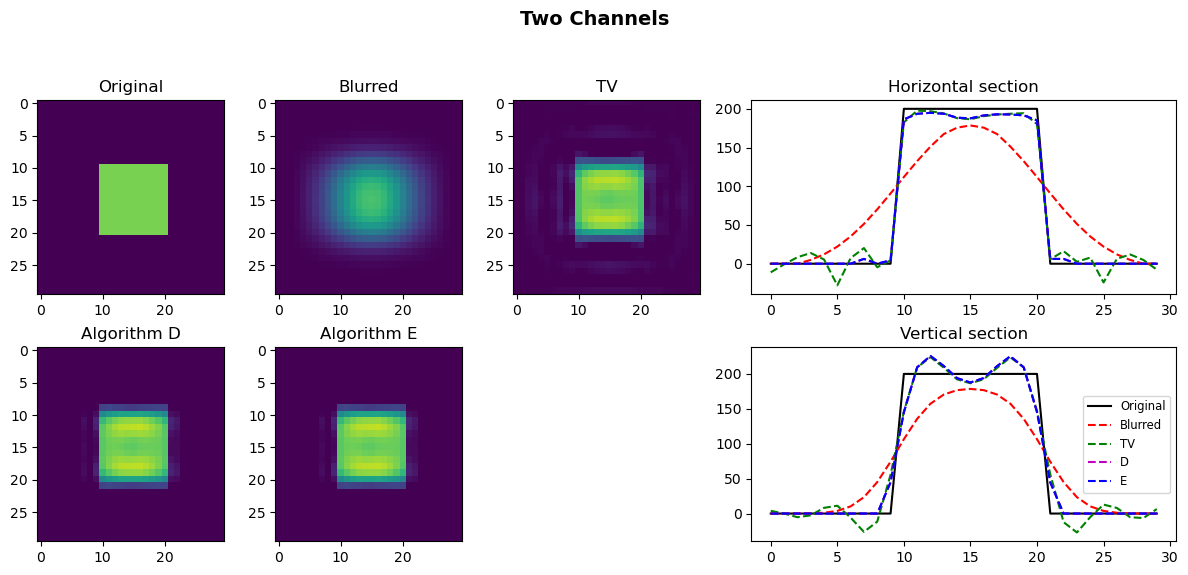

In [71]:
image = np.zeros((Nz, Nx, 3), np.uint8)
image[:,:,0] = imG
image[:,:,1] = imB
image[:,:,2] = imR

#blur the images
imblurG = Cop * imG
imblurB = Cop * imB
imblurR = Cop * imR

Jim = np.array([imG, imB, imR])
Jimblur = np.array([imblurG, imblurB, imblurR])

imblur = np.zeros((Nz, Nx, 3), np.uint8)
imblur[:,:,0] = Jimblur[0]
imblur[:,:,1] = Jimblur[1]
imblur[:,:,2] = Jimblur[2]

D = alg_D(Jimblur)
E = alg_E(Jimblur)
TV = JTV_inv(Jimblur, 3)

# Create a Nz x Nx image with RGB as the first dimension

D_image = np.zeros((Nz, Nx, 3), np.uint8)
D_image[:,:,0] = np.round(D[0])
D_image[:,:,1] = np.round(D[1])
D_image[:,:,2] = np.round(D[2])

E_image = np.zeros((Nz, Nx, 3), np.uint8)
E_image[:,:,0] = np.round(E[0])
E_image[:,:,1] = np.round(E[1])
E_image[:,:,2] = np.round(E[2])

TV_image = np.zeros((Nz, Nx, 3), np.uint8)
TV_image[:,:,0] = TV[0]
TV_image[:,:,1] = TV[1]
TV_image[:,:,2] = TV[2]

plot_result(Jim[0], Jimblur[0], TV[0], D[0], E[0])
#plot_alg(A_image, B_image, C_image, D_image, E_image, F_image, G_image, TV_image, image, imblur)

# PLOT PSNR:
print("PSNR")
print("TV", calculate_psnr(TV, Jim))
print("D", calculate_psnr(D, Jim))
print("E", calculate_psnr(E, Jim))

print("SSIM")
print("TV", ssim(np.array(TV), Jim, data_range = 255, channel_axis = 0))
print("D", ssim(np.array(D), Jim, data_range = 255, channel_axis = 0))
print("E", ssim(np.array(E), Jim, data_range = 255, channel_axis = 0))

In [77]:
print("GD", J(imG, imB, imR, 'GD') ,J(imblurG, imblurB, imblurR, 'GD'))
print("N", J(imG, imB, imR, 'N') ,J(imblurG, imblurB, imblurR, 'N'))
print("CG", J(imG, imB, imR, 'CG') ,J(imblurG, imblurB, imblurR, 'CG'))
print("jCG", J(imG, imB, imR, 'jCG') ,J(imblurG, imblurB, imblurR, 'jCG'))
print("jN", J(imG, imB, imR, 'jN') ,J(imblurG, imblurB, imblurR, 'jN'))

GD 488.8888888888889 68.87802347318257
N 20.113259553750687 nan
CG 182044.44444444444 1.35925703157535e-13
jCG 182044.44444444444 0.0
jN 28.444444444444443 0.0


C:\Users\schil\AppData\Local\Temp\ipykernel_22816\2374389777.py:90: RuntimeWarning: invalid value encountered in sqrt
  val = np.sqrt((xi[0][0] * xi[1][1])**2 + (xi[0][0] * xi[2][1])**2 + (xi[1][0] * xi[0][1])**2 + (xi[1][0] * xi[2][1])**2 + (xi[2][0] * xi[0][1])**2 + (xi[2][0] * xi[1][1])**2 - 2 *(xi[0][0] * xi[0][1] * xi[1][0] * xi[1][1] + xi[0][0] * xi[0][1] * xi[2][0] * xi[2][1] + xi[1][0] * xi[1][1] * xi[2][0] * xi[2][1]))


In [66]:
print("TV", calculate_psnr(TV, Jim))
print("TV", ssim(np.array(TV), Jim, data_range = 255, channel_axis = 0))

for beta in [1e-4, 1e-3, 1e-2, 1e-1, 1e0]:
    
    def alg_A(im, a = 1, b = beta, maxiter = 2000, ftol = 1e-6, gtol = 1e-6):
        result = sp.optimize.minimize(f_switch, x0 = np.array([im[0], im[1], im[2]]).ravel(), jac = True, method = 'L-BFGS-B', args = (a, b, 'CG'), bounds = generate_bounds(3 * Nz * Nx, 0, 255), options = {'maxiter' : maxiter, 'ftol' : ftol, 'gtol' : gtol})
        return vector_to_image(result.x, Nz, Nx)
    
    D = alg_D(Jimblur)
    E = alg_E(Jimblur)
    print("D", calculate_psnr(D, Jim))
    print("E", calculate_psnr(E, Jim))
    print("D", ssim(np.array(D), Jim, data_range = 255, channel_axis = 0))
    print("E", ssim(np.array(E), Jim, data_range = 255, channel_axis = 0))
    

TV 25.726674372298355
TV 0.7691350861256442
D 26.788833466119687
E 26.788833466119687
D 0.8873227273705734
E 0.8873227273705734
D 26.815910588648364
E 26.815910588648364
D 0.887612761551312
E 0.887612761551312
D 27.09629100623846
E 27.09629100623846
D 0.877866735801824
E 0.877866735801824
D 26.560676419455262
E 26.560676419455262
D 0.7434829532699979
E 0.7434829532699979
D 26.2843959510773
E 26.2843959510773
D 0.7705749200688335
E 0.7705749200688335
